# Let's Train GPT-3



### Configure the machine and install packages


In [1]:
from typing import Literal

import jax

platform : Literal["darwin", "colab", "cuda"] = "darwin"

try:
    import google.colab
    platform = "colab"
except ImportError:
    devices = jax.devices()
    if any(d.platform == "gpu" for d in devices):
        platform = "cuda"

print(f"Running on {platform}")

if platform == "colab":
    !git clone https://github.com/novastar53/jaxpt
    !cd jaxpt && git checkout main && git pull
    !pip install tiktoken --quiet
    !pip uninstall -y tensorflow

Running on cuda


In [2]:
from pathlib import Path
import sys

if platform == "colab":
    jaxpt_dir = str(Path().absolute() / "jaxpt" / "src" )
else:
    jaxpt_dir = str(Path().absolute().parent / "src" )

sys.path.append(jaxpt_dir)
print(jaxpt_dir)

/home/ubuntu/jaxpt/src


In [3]:
import os
import warnings

import jax
import flax
import jax.numpy as jnp
import numpy as np

os.environ['XLA_FLAGS'] = (
    '--xla_gpu_triton_gemm_any=True '
    '--xla_gpu_enable_latency_hiding_scheduler=true '
)

os.environ.update({
  "NCCL_LL128_BUFFSIZE": "-2",
  "NCCL_LL_BUFFSIZE": "-2",
  "NCCL_PROTO": "SIMPLE,LL,LL128",
 })


# Hardware setup
print("JAX version:", jax.__version__)
print("Flax version", flax.__version__)
devices = jax.devices()
num_devices = len(devices)
print("Available devices:", num_devices)

requested_device = "gpu"

jax.config.update("jax_platform_name", requested_device) # Make sure we're using the GPU

device = jax.default_backend()
if device != requested_device:
    warnings.warn(f"not using {requested_device}. Using {device}")
else:
    print(f"using {device}")


#####################################
##        jax.lax matmul presets   ##
#####################################
## 'ANY_F8_ANY_F8_F32',
## 'ANY_F8_ANY_F8_F32_FAST_ACCUM'
## 'ANY_F8_ANY_F8_ANY'
## 'ANY_F8_ANY_F8_ANY_FAST_ACCUM'
## 'F16_F16_F16'
## 'F16_F16_F32'
## 'BF16_BF16_BF16'
## 'BF16_BF16_F32'
## 'BF16_BF16_F32_X3'
## 'BF16_BF16_F32_X6'
## 'TF32_TF32_F32'
## 'TF32_TF32_F32_X3'
## 'F32_F32_F32'
## 'F64_F64_F64'
#####################################

jax.config.update("jax_default_matmul_precision", "BF16_BF16_F32") # Set the default precision for matrix multiplication

#jax.config.update("jax_enable_x64", True) # Make sure the highest precision is enabled in case we need
#os.environ["NVIDIA_TF32_OVERRIDE"] = "1"
#os.environ["JAX_ENABLE_X64"] = "False"

if device == "tpu":
    def list_tpu_memory():
        devices = jax.devices()
        for device in devices:
            if 'TPU' in str(device.device_kind):
                print(f"Device: {device}, Memory: {device.memory_stats()['bytes_limit']/(1024*1024)},  Used: {device.memory_stats()['bytes_in_use']/(1024*1024)}")

    list_tpu_memory()

# Test the device
A = jnp.array(np.random.normal(size=(4096, 4096)), dtype=jnp.float32) # Makes sure the matmul is fast
%timeit (A@A).block_until_ready()

JAX version: 0.5.2
Flax version 0.10.4
Available devices: 8
using gpu
344 μs ± 14 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Initialize the GPT-3 model and perform a sanity check

In [4]:
from flax import nnx

from jaxpt.infer import generate_completions
from jaxpt.models import RoPE_GPT, RoPE_GPTConfig
from jaxpt.utils import count_params


key = jax.random.PRNGKey(1337)
rngs = nnx.Rngs(key)
config = RoPE_GPTConfig(dtype=jnp.bfloat16, \
                   vocab_size=50304, \
                   block_size=1024, \
                   n_layer=24, \
                   n_embed=1024, \
                   n_head=16, \
                   sdpa_implementation="cudnn" if device=="gpu" else "xla")
nnx.display(config)
m = RoPE_GPT(config, rngs)


#m = load_checkpoint("run_20250311_uqdwjq", 5600)
graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
total_params = count_params(m)

print(f"Parameter Count: {total_params:,}")
nnx.display(state)

#completions = generate_completions()
#for completion in completions:
#print(completion)


Parameter Count: 353,822,720


### Configure Training Run

In [5]:
from datetime import datetime
import random
import string


def generate_random_code(length=6):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

timestamp = datetime.now().strftime("%Y%m%d")
random_code = generate_random_code()

run_dirname = f"run_{timestamp}_{random_code}"
print(f"Run: {run_dirname}")

if platform == "colab":
  output_dir = Path().absolute().parent
elif platform == "cuda":
  output_dir = Path("/home/ubuntu/gpt2-train") # Lambda Labs setup
else:
  output_dir = Path().absolute().parent # Local setup

# Create checkpoint dir
checkpoint_dir = output_dir / "checkpoints"
checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"Checkpoint directory: {checkpoint_dir}")

# Create log dir
log_dir = output_dir / "logs"
log_dir.mkdir(parents=True, exist_ok=True)
print(f"Log directory: {log_dir}")

def save_checkpoint(m, run_dirname, step):
  checkpoint_path = checkpoint_dir / run_dirname / f"checkpoint-{step}.pt"
  m.save_checkpoint(checkpoint_path)

def load_checkpoint(model, run_dirname, step):
  checkpoint_path = checkpoint_dir / run_dirname / f"checkpoint-{step}.pt"
  m = model.load_checkpoint(checkpoint_path, rngs)
  return m

Run: run_20250430_magovd
Checkpoint directory: /home/ubuntu/gpt2-train/checkpoints
Log directory: /home/ubuntu/gpt2-train/logs


In [9]:
import dataclasses

import optax


############################
# Nvidia A100 (x 8) Config #
############################

@dataclasses.dataclass
class TrainerConfig:
  num_tokens_per_batch: int = 2**19 # 2**19, 0.5 million as per the GPT 3.5 paper
  mB: int = 48
  T: int = 1024
  max_steps: int = (300 * 100e6) // (2**19) # Roughly 1/3rd of the 100b token dataset
  max_lr: float = 3 * 6e-4
  min_lr: float = max_lr * 0.1
  max_grad_norm: float = 1.0  # Clip gradients to this norm
  warmup_steps: int = 715 * 5
  print_interval: int = 125
  eval_interval: int = 5000
  checkpoint_interval: int = 10000
  grad_accumulation_steps: int = num_tokens_per_batch // (mB * T * num_devices) # Number of steps over which to average the gradient


##############
# CPU Config #
##############

trconf = TrainerConfig()
'''
trconf = TrainerConfig(
  num_tokens_per_batch=2**9,
  mB=2**4,
  T=2**5,
  max_steps=9*48, # 6 epoch(s)
  max_lr=6e-4,
  min_lr=6e-5,
  max_grad_norm=1.0,
  warmup_steps=10,
  print_interval=1,
  eval_interval=50,
  checkpoint_interval=0,

)

trconf.grad_accumulation_steps =  trconf.num_tokens_per_batch // (trconf.mB * trconf.T * num_devices) # Number of steps over which to average the gradient
'''
# Set up the optimizer
def warmup_with_cosine_decay_schedule(step):

    warmup_lr = trconf.max_lr * (step + 1) / trconf.warmup_steps
    coeff = 0.5 * (1 + jnp.cos(jnp.pi * (step - trconf.warmup_steps) / (trconf.max_steps - trconf.warmup_steps)))
    cosine_lr =  trconf.min_lr + coeff * (trconf.max_lr - trconf.min_lr)

    return jnp.where(step < trconf.warmup_steps,
                     warmup_lr,
                     jnp.where(step < trconf.max_steps, cosine_lr, trconf.min_lr))

# Generate a weight decay mask
# First split the model into params and variables
graphdef, params, variables = nnx.split(m, nnx.Param, nnx.Variable)
# Then create a mask for the weight decay params
weight_decay_mask = jax.tree_util.tree_map(lambda x: len(x.shape) > 1, params)


tx = optax.chain(
    optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adamw(warmup_with_cosine_decay_schedule, b1=0.9, b2=0.95, weight_decay=0.1, mask=weight_decay_mask)
)
optimizer = nnx.Optimizer(m, tx)

# count the number of weight decay params
def f(x, y):
    if x:
        return y.size
    return 0

weight_decay_params = jax.tree_util.tree_map(f, weight_decay_mask, params)
weight_decay_param_count = jax.tree_util.tree_reduce(lambda x, y: x + y, weight_decay_params, 0)


print(f"weight decay param count: {weight_decay_param_count:,}")
print(f"tokens/batch: {trconf.num_tokens_per_batch:,}")
print(f"block size: {trconf.T}")
print(f"sub-batch size: {trconf.mB}")
print(f"no. gradient accumulation steps: {trconf.grad_accumulation_steps}")
print(f"effective batch size per device: ", trconf.grad_accumulation_steps * trconf.mB)
print(f"effective batch size: {trconf.grad_accumulation_steps * trconf.mB * num_devices}")
print(f"max steps: {trconf.max_steps:,}")


weight decay param count: 353,501,184
tokens/batch: 524,288
block size: 1024
sub-batch size: 48
no. gradient accumulation steps: 1
effective batch size per device:  48
effective batch size: 384
max steps: 57,220.0


### DataLoader and Validation Setup



In [7]:
import os

from jaxpt.dataloaders import CloudDataLoader
from jaxpt.eval import calc_validation_loss
from jaxpt.train import loss_fn

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../alpha-448101-282bc1b884cd.json"

train_dl = CloudDataLoader(bucket_name="jaxpt_datasets",
                      bucket_prefix="fineweb-edu-100b/processed",
                      batch_size=trconf.mB,
                      block_size=trconf.T,
                      device_rank=num_devices,
                      label="train")
eval_dl = CloudDataLoader(bucket_name="jaxpt_datasets",
                     bucket_prefix="fineweb-edu-100b/processed",
                     batch_size=trconf.mB,
                     block_size=trconf.T,
                     device_rank=1,
                     label="valid")

def evaluate(model):
  model.eval()
  completions = generate_completions(model)
  val_loss = calc_validation_loss(model, loss_fn=loss_fn, dataloader=eval_dl)
  model.train()
  return val_loss, completions

step = 0

CloudDataLoader initialized:
------------------------
label:          train
shards:         991
shard size:     100,000,000
batch size:     48
block size:     1024
device rank:    8
------------------------
CloudDataLoader initialized:
------------------------
label:          valid
shards:         11
shard size:     100,000,000
batch size:     48
block size:     1024
device rank:    1
------------------------


In [ ]:
train_losses = []
val_losses = []
append_to_csv(log_dir / f"{run_dirname}_train.csv", ["step", "lr", "loss", "norm", "time", "tokens_processed", "tokens_per_sec"])
append_to_csv(log_dir / f"{run_dirname}_valid.csv", ["step", "loss"])

Received KeyboardInterrupt. Exiting...norm: 0.00 | time: 324.99ms | tokens processed: 5,751,177,216 | tok/sec: 1,209,930.71
valid loss: 2.9844
Hello, I'm a language model, my_like me !!") [else ] I haven
Hello, I'm a language model, anyway!" Asynchronous communications in it may it doesn of messages
Hello, I'm a language model, how come to what I find what's i'm doing...
Hello, I'm a language model, the way round and a game development platform on my main interface
Hello, I'm a language model, it only an actual name was done you wanna
you do


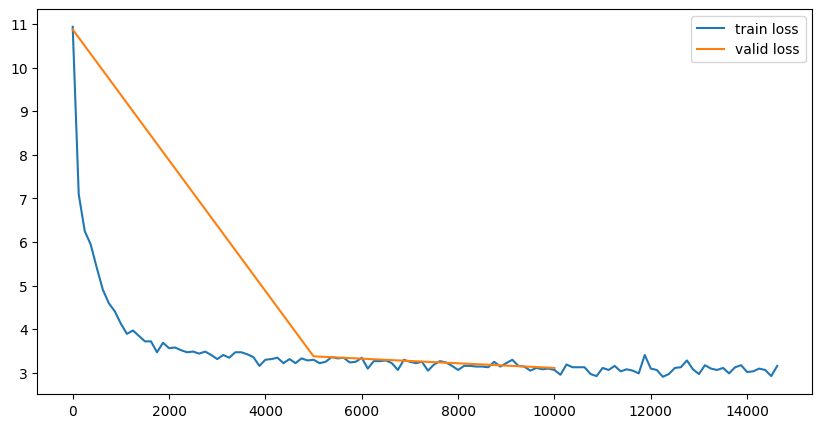

In [13]:
%matplotlib inline

import time

import matplotlib.pyplot as plt

from jaxpt.utils import append_to_csv
from jaxpt.train import parallel_train_step

m.train()
try:
  while step < trconf.max_steps:
    start = time.time()
    batch, target = train_dl()
    avg_loss, avg_grads = parallel_train_step(m, optimizer, batch, target)
    avg_loss.block_until_ready()
    # compute stats
    avg_loss = jnp.float32(avg_loss[0])
    lr = warmup_with_cosine_decay_schedule(step)
    norm = 0 # norm[0]|
    iter_time = time.time() - start
    sub_step_time = iter_time / trconf.grad_accumulation_steps
    tokens_per_sec = num_devices * trconf.mB * trconf.T * trconf.grad_accumulation_steps / iter_time
    tokens_processed = (step+1) * num_devices * trconf.grad_accumulation_steps * trconf.mB * trconf.T

    if step % trconf.print_interval == 0:
      train_losses.append((step, avg_loss))
      append_to_csv(log_dir / f"{run_dirname}_train.csv", [step, lr, avg_loss, norm, iter_time*1000, tokens_processed, tokens_per_sec])
      print(f"{step} | lr: {lr:0.2e} | loss: {avg_loss:0.4f} | norm: {norm:0.2f} | time: {iter_time*1000:0.2f}ms | tokens processed: {tokens_processed:,} | tok/sec: {tokens_per_sec:,.2f}", end="\r")
    if step % trconf.eval_interval == 0:
      valid_loss, completions = evaluate(m)
      valid_loss = jnp.float32(valid_loss)
      val_losses.append((step, valid_loss))
      append_to_csv(log_dir / f"{run_dirname}_valid.csv", [step, valid_loss])
      print(f"valid loss: {valid_loss:0.4f}"  )
      for completion in completions:
        print(completion)
    #if step > 0 and trconf.checkpoint_interval > 0 and step % trconf.checkpoint_interval == 0:
      #save_checkpoint(m, run_dirname, step)
    step += 1
      
except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")

valid_loss, completions = evaluate(m)
valid_loss = jnp.float32(valid_loss)
print(f"valid loss: {valid_loss:0.4f}")
for completion in completions:
  print(completion)
plt.figure(figsize=(10, 5))
plt.plot([x[0] for x in train_losses], [x[1] for x in train_losses], label="train loss")
plt.plot([x[0] for x in val_losses], [x[1] for x in val_losses], label="valid loss")
plt.legend()
plt.savefig(log_dir / f"{run_dirname}.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()
